In [4]:
import requests

In [5]:
r = requests.get('http://www.citibikenyc.com/stations/json')

In [6]:
type(r)

requests.models.Response

In [7]:
r.

SyntaxError: invalid syntax (<ipython-input-7-ea092d2967a4>, line 1)

In [8]:
r.text

u'{"executionTime":"2015-07-13 08:21:10 PM","stationBeanList":[{"id":72,"stationName":"W 52 St & 11 Ave","availableDocks":15,"totalDocks":39,"latitude":40.76727216,"longitude":-73.99392888,"statusValue":"In Service","statusKey":1,"availableBikes":23,"stAddress1":"W 52 St & 11 Ave","stAddress2":"","city":"","postalCode":"","location":"","altitude":"","testStation":false,"lastCommunicationTime":"2015-07-13 08:20:26 PM","landMark":""},{"id":79,"stationName":"Franklin St & W Broadway","availableDocks":31,"totalDocks":33,"latitude":40.71911552,"longitude":-74.00666661,"statusValue":"In Service","statusKey":1,"availableBikes":0,"stAddress1":"Franklin St & W Broadway","stAddress2":"","city":"","postalCode":"","location":"","altitude":"","testStation":false,"lastCommunicationTime":"2015-07-13 08:20:15 PM","landMark":""},{"id":82,"stationName":"St James Pl & Pearl St","availableDocks":9,"totalDocks":27,"latitude":40.71117416,"longitude":-74.00016545,"statusValue":"In Service","statusKey":1,"ava

In [9]:
r.json()

{u'executionTime': u'2015-07-13 08:21:10 PM',
 u'stationBeanList': [{u'altitude': u'',
   u'availableBikes': 23,
   u'availableDocks': 15,
   u'city': u'',
   u'id': 72,
   u'landMark': u'',
   u'lastCommunicationTime': u'2015-07-13 08:20:26 PM',
   u'latitude': 40.76727216,
   u'location': u'',
   u'longitude': -73.99392888,
   u'postalCode': u'',
   u'stAddress1': u'W 52 St & 11 Ave',
   u'stAddress2': u'',
   u'stationName': u'W 52 St & 11 Ave',
   u'statusKey': 1,
   u'statusValue': u'In Service',
   u'testStation': False,
   u'totalDocks': 39},
  {u'altitude': u'',
   u'availableBikes': 0,
   u'availableDocks': 31,
   u'city': u'',
   u'id': 79,
   u'landMark': u'',
   u'lastCommunicationTime': u'2015-07-13 08:20:15 PM',
   u'latitude': 40.71911552,
   u'location': u'',
   u'longitude': -74.00666661,
   u'postalCode': u'',
   u'stAddress1': u'Franklin St & W Broadway',
   u'stAddress2': u'',
   u'stationName': u'Franklin St & W Broadway',
   u'statusKey': 1,
   u'statusValue': u'I

In [10]:
r.json().keys()

[u'executionTime', u'stationBeanList']

In [11]:
r.json()['executionTime']

u'2015-07-13 08:21:10 PM'

In [12]:
# Number of citi bike stations
len(r.json()['stationBeanList'])

329

In [13]:
# Create a list of all keys in stationBeanList
key_list = []
for station in r.json()['stationBeanList']:
    for k in station.keys():
        if k not in key_list:
            key_list.append(k)

In [14]:
key_list

[u'availableDocks',
 u'totalDocks',
 u'city',
 u'altitude',
 u'stAddress2',
 u'longitude',
 u'lastCommunicationTime',
 u'postalCode',
 u'statusValue',
 u'testStation',
 u'stAddress1',
 u'stationName',
 u'landMark',
 u'latitude',
 u'statusKey',
 u'availableBikes',
 u'id',
 u'location']

In [15]:
# Import the data into a dataframe
from pandas.io.json import json_normalize
df = json_normalize(r.json()['stationBeanList'])

In [16]:
df.head()

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks
0,,23,15,,72,,2015-07-13 08:20:26 PM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,39
1,,0,31,,79,,2015-07-13 08:20:15 PM,40.719116,,-74.006667,,Franklin St & W Broadway,,Franklin St & W Broadway,1,In Service,False,33
2,,18,9,,82,,2015-07-13 08:19:36 PM,40.711174,,-74.000165,,St James Pl & Pearl St,,St James Pl & Pearl St,1,In Service,False,27
3,,50,7,,83,,2015-07-13 08:18:50 PM,40.683826,,-73.976323,,Atlantic Ave & Fort Greene Pl,,Atlantic Ave & Fort Greene Pl,1,In Service,False,62
4,,31,7,,116,,2015-07-13 08:20:12 PM,40.741776,,-74.001497,,W 17 St & 8 Ave,,W 17 St & 8 Ave,1,In Service,False,39


<function matplotlib.pyplot.show>

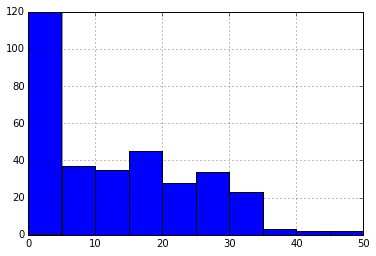

In [17]:
# Check the range of values, starting with available bikes
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
df['availableBikes'].hist()
plt.show

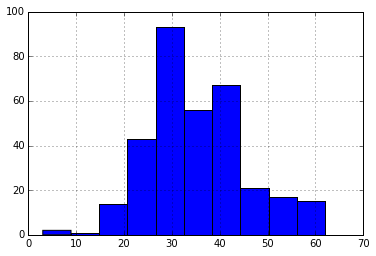

In [18]:
df['totalDocks'].hist()

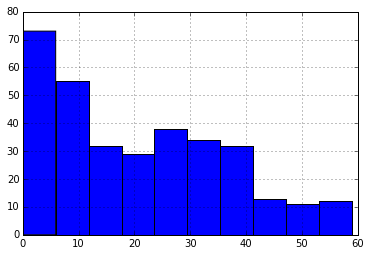

In [19]:
df['availableDocks'].hist()

In [21]:
# Make a plot that shows the percent available of each dock
avail = df['availableBikes']

In [22]:
total = df['totalDocks']

In [23]:
df2 = avail / total

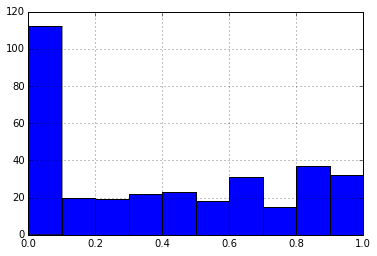

In [25]:
df2.hist()

In [26]:
df['availableBikes'].max()

50

Exercises

In [38]:
# Are there any test stations?
testStations = []
for index, row in df.iterrows():
    if row['testStation'] == True:
        testStations.append(index)

In [40]:
testStations

[]

In [41]:
# There are no test stations

In [47]:
# How many are in service?
inService = 0
for index, row in df.iterrows():
    if row['statusValue'] == 'In Service':
        inService += 1
        

In [48]:
inService

326

In [50]:
# A better way of doing what I just did
df.groupby('statusValue').size()

statusValue
In Service        326
Not In Service      3
dtype: int64

In [51]:
df.groupby('statusKey').size()

statusKey
1            326
3              3
dtype: int64

In [52]:
# What is statusKey?

In [54]:
# What is the mean number of bikes in a dock?
df['availableBikes'].mean()

12.699088145896656

In [55]:
# What is the median?
df['availableBikes'].median()

11.0

In [56]:
# How does this change if we remove the docs that are not in service?

In [58]:
df2 = df[df.statusValue == 'In Service']

In [59]:
df2['availableBikes'].mean()

12.815950920245399

In [60]:
df2['availableBikes'].median()

11.0

In [61]:
len(df2)

326

In [62]:
len(df)

329

In [ ]:
# A better way to do what I just did
df[d